In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [72]:
df = pd.read_csv("..\Data\TotalWithMissing.csv")
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [73]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [74]:
df.fillna(0.0, inplace = True)

In [75]:
TRAIN_SPLIT = 14400

In [76]:
tf.random.set_seed(42)

In [77]:
tec_data = df["TEC"]
tec_data.head()

0    2.067562
1    2.082707
2    2.004272
3    1.736569
4    1.758503
Name: TEC, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F72BE7748>],
      dtype=object)

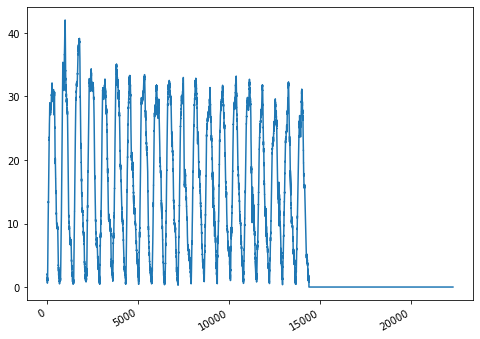

In [78]:
tec_data.plot(subplots=True)

In [79]:
tec_data = tec_data.values

In [80]:
tec_data_mean = tec_data[:TRAIN_SPLIT].mean()
tec_data_std = tec_data[:TRAIN_SPLIT].std()

In [81]:
tec_data = (tec_data-tec_data_mean)/tec_data_std

In [82]:
tec_past_data = 20
tec_future_target = 0

x_train_tec, y_train_tec = univariate_data(tec_data, 0, TRAIN_SPLIT,
                                           tec_past_data,
                                           tec_future_target)
x_val_tec, y_val_tec = univariate_data(tec_data, TRAIN_SPLIT, None,
                                       tec_past_data,
                                       tec_future_target)

In [83]:
print ('Single window of past history')
print (x_train_tec[0])
print ('\n Target TEC to predict')
print (y_train_tec[0])

Single window of past history
[[-1.39285503]
 [-1.39144387]
 [-1.39875223]
 [-1.42369602]
 [-1.42165229]
 [-1.44114681]
 [-1.42325594]
 [-1.45869923]
 [-1.48717231]
 [-1.47877957]
 [-1.48895448]
 [-1.46467981]
 [-1.46290419]
 [-1.46724047]
 [-1.49581416]
 [-1.5279739 ]
 [-1.49340236]
 [-1.48272126]
 [-1.49121556]
 [-1.48929057]]

 Target TEC to predict
-1.4761595700059122


In [84]:
def create_time_steps(length):
  return list(range(-length, 0))

In [85]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

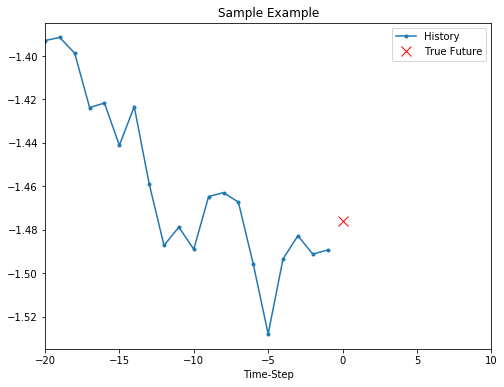

In [86]:
show_plot([x_train_tec[0], y_train_tec[0]], 0, 'Sample Example')

In [87]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

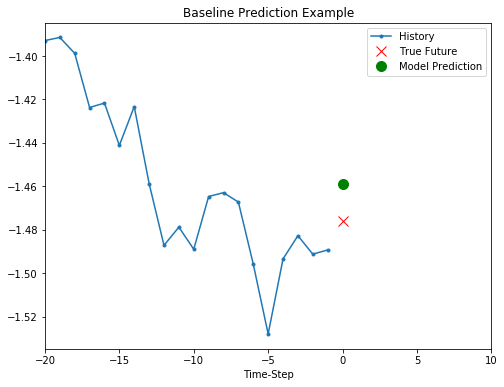

In [88]:
show_plot([x_train_tec[0], y_train_tec[0], baseline(x_train_tec[0])], 0,
           'Baseline Prediction Example')

In [89]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_tec, y_train_tec))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_tec, y_val_tec))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [90]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_tec.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [91]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [92]:
EVALUATION_INTERVAL = 200
EPOCHS = 25

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 3s 15ms/step - loss: 0.2956 - val_loss: 0.2594
Epoch 2/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0427 - val_loss: 0.0525
Epoch 3/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0409
Epoch 4/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0253 - val_loss: 0.0224
Epoch 5/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0236 - val_loss: 0.0222
Epoch 6/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0228 - val_loss: 0.0135
Epoch 7/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0219 - val_loss: 0.0119
Epoch 8/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0213 - val_loss: 0.0076
Epoch 9/25
200/200 [==============================] - 1s 7ms/step - loss: 0.0208 - val_loss: 0.0029
Epoch 10/25
200/200 [==============================] - 1

[-1.5799347]


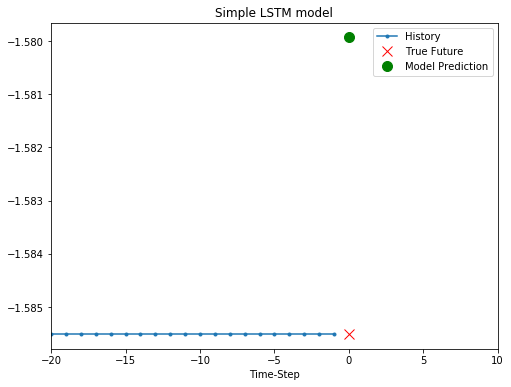

[-1.5799347]


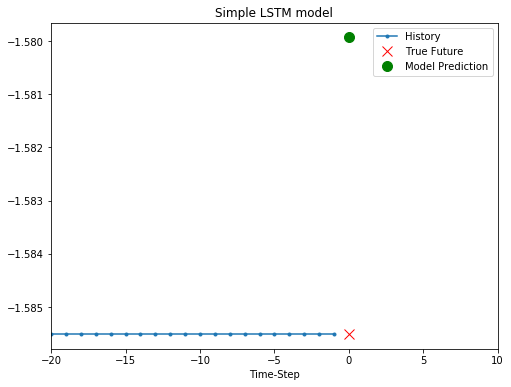

[-1.5799347]


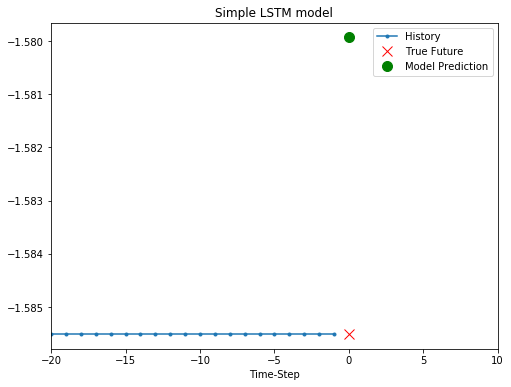

[-1.5799347]


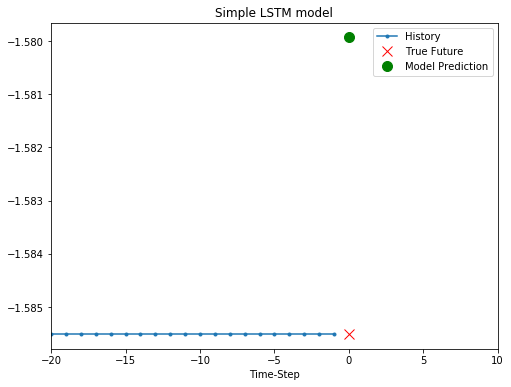

[-1.5799347]


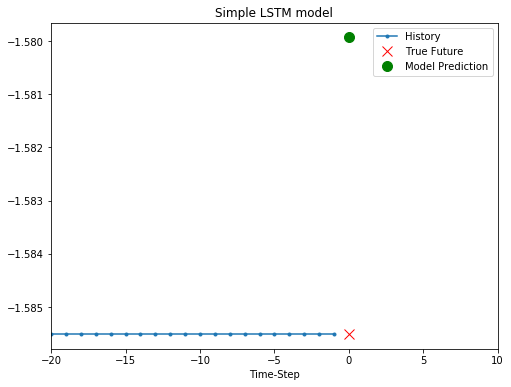

[-1.5799347]


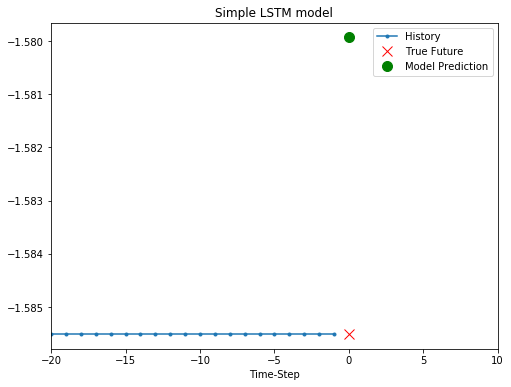

[-1.5799347]


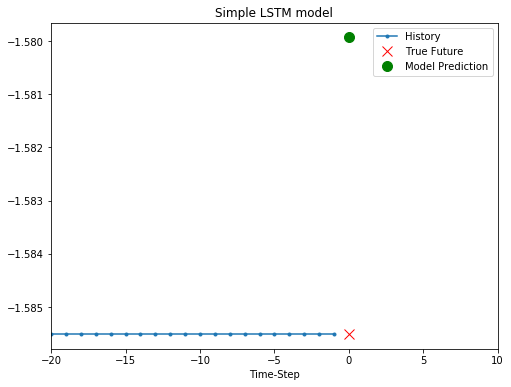

[-1.5799347]


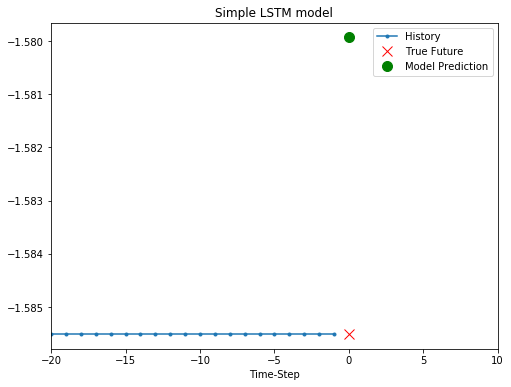

[-1.5799347]


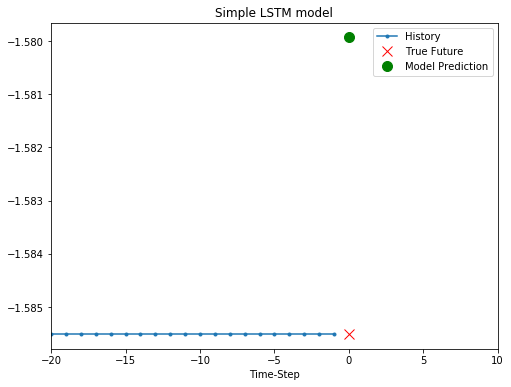

[-1.5799347]


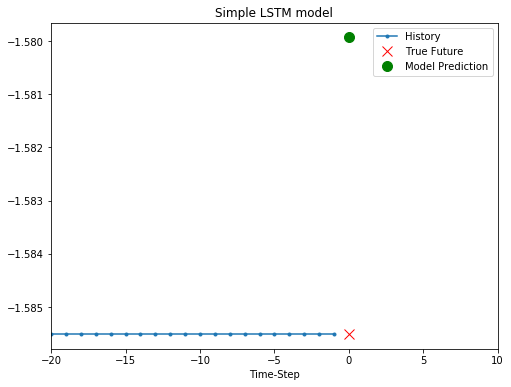

[array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32),
 array([-1.5799347], dtype=float32)]

In [125]:
preds = []
for x, y in val_univariate.take(10):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    preds.append(simple_lstm_model.predict(x)[0])
    print(simple_lstm_model.predict(x)[0])
    plot.show()

preds

In [94]:
features_considered = ['Time', "TEC"]

In [95]:
features = df[features_considered]
features.head()

,Time,TEC
0,0.016389,2.067562
1,0.049722,2.082707
2,0.083056,2.004272
3,0.116389,1.736569
4,0.149722,1.758503


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024F74A3A988>,
      dtype=object)

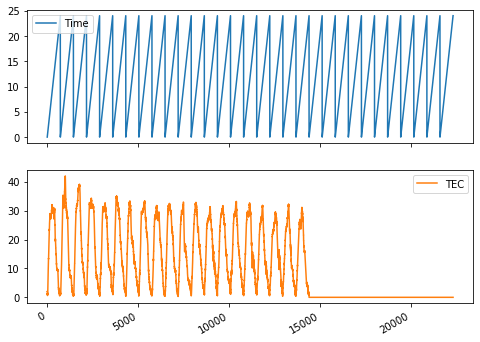

In [96]:
features.plot(subplots=True)


In [97]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [98]:
dataset = (dataset-data_mean)/data_std

In [99]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [100]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [101]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 2)


In [102]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [103]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [104]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [105]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 23s 113ms/step - loss: 0.2295 - val_loss: 1.6974
Epoch 2/25
200/200 [==============================] - 21s 107ms/step - loss: 0.1712 - val_loss: 1.5989
Epoch 3/25
200/200 [==============================] - 21s 106ms/step - loss: 0.1640 - val_loss: 1.7792
Epoch 4/25
200/200 [==============================] - 21s 106ms/step - loss: 0.1561 - val_loss: 1.7841
Epoch 5/25
200/200 [==============================] - 21s 105ms/step - loss: 0.1515 - val_loss: 1.6960
Epoch 6/25
200/200 [==============================] - 21s 105ms/step - loss: 0.1472 - val_loss: 1.6647
Epoch 7/25
200/200 [==============================] - 21s 105ms/step - loss: 0.1449 - val_loss: 1.6193
Epoch 8/25
200/200 [==============================] - 21s 106ms/step - loss: 0.1418 - val_loss: 1.5116
Epoch 9/25
200/200 [==============================] - 21s 106ms/step - loss: 0.1388 - val_loss: 1.5028
Epoch 10/25
200/200 [=========

In [106]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

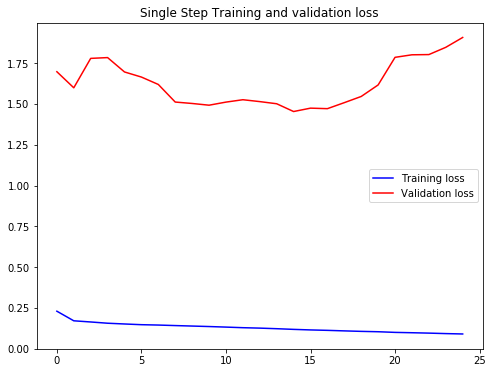

In [107]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

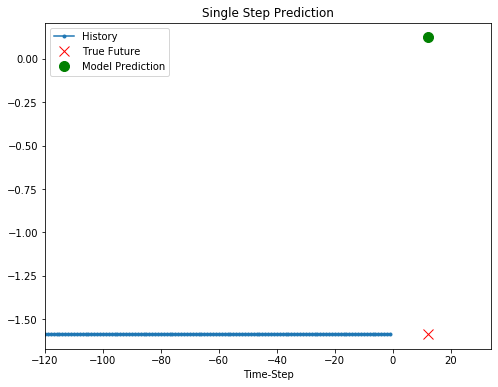

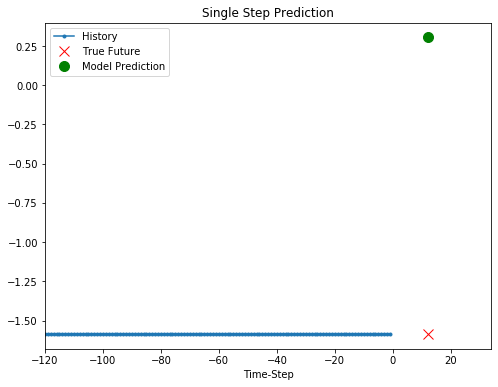

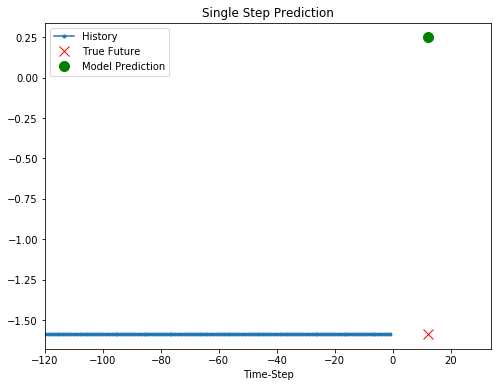

In [108]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [109]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [110]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [111]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 2)

 Target temperature to predict : (72,)


In [112]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [113]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

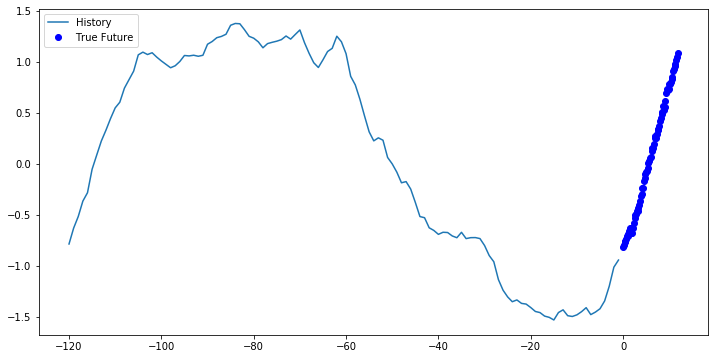

In [114]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [115]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [116]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [117]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 41s 206ms/step - loss: 2.6946 - val_loss: 1.1873
Epoch 2/25
200/200 [==============================] - 39s 197ms/step - loss: 0.1846 - val_loss: 0.9646
Epoch 3/25
200/200 [==============================] - 39s 196ms/step - loss: 0.1573 - val_loss: 0.9386
Epoch 4/25
200/200 [==============================] - 40s 198ms/step - loss: 0.1458 - val_loss: 0.9245
Epoch 5/25
200/200 [==============================] - 39s 196ms/step - loss: 0.1372 - val_loss: 0.8784
Epoch 6/25
200/200 [==============================] - 39s 197ms/step - loss: 0.1305 - val_loss: 0.8666
Epoch 7/25
200/200 [==============================] - 40s 198ms/step - loss: 0.1255 - val_loss: 0.8426
Epoch 8/25
200/200 [==============================] - 40s 198ms/step - loss: 0.1220 - val_loss: 0.8883
Epoch 9/25
200/200 [==============================] - 40s 198ms/step - loss: 0.1189 - val_loss: 0.8801
Epoch 10/25
200/200 [=========

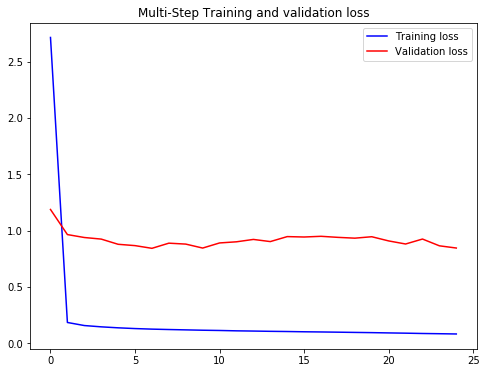

In [118]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

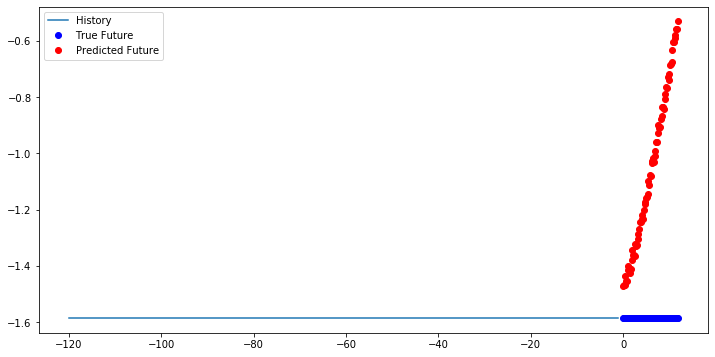

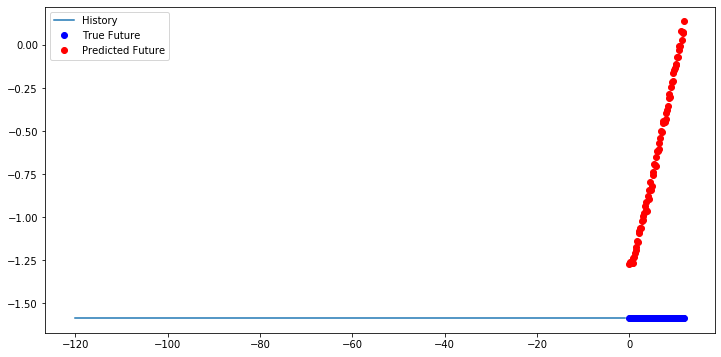

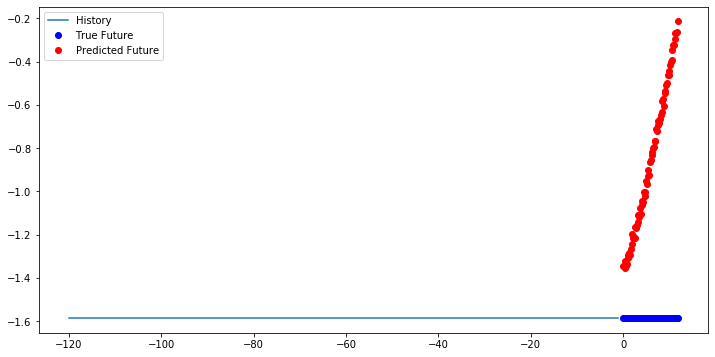

In [119]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])